<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/seg1105Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

In [103]:
# !pip install tqdm

In [104]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import torch.nn.utils.prune as prune
import torch_pruning as tp
import time
from ptflops import get_model_complexity_info
from fvcore.nn import FlopCountAnalysis
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_motor30'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 및 전처리 함수 정의
class VibrationDataset(Dataset):
    def __init__(self, base_dir, split, categories, label_encoder, segment_length=4000, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        self.segment_length = segment_length
        self.file_count = defaultdict(int)  # 카테고리별 파일 개수를 저장할 딕셔너리

        split_dir = os.path.join(base_dir, split)
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            files = os.listdir(category_dir)
            self.file_count[category] = len(files)  # 카테고리별 파일 수 저장

            for file in files:
                file_path = os.path.join(category_dir, file)
                data = pd.read_csv(file_path, header=None, skiprows=1)  # 첫 행 건너뜀

                # 첫 번째 열(시간 데이터)을 제외하고 주파수 데이터만 선택
                frequency_data = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values

                # 데이터를 세그먼트로 분할
                num_segments = frequency_data.shape[0] // self.segment_length
                for i in range(num_segments):
                    segment = frequency_data[i * self.segment_length:(i + 1) * self.segment_length]
                    self.X.append(segment)  # 주파수 데이터만 포함
                    self.y.append(label_encoder.transform([category])[0])

        # 카테고리별 파일 개수 출력
        print(f"File count for '{split}' split:")
        for category, count in self.file_count.items():
            print(f"  {category}: {count} files")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T  # 2D 입력 (채널, 길이)로 변경
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# 레이블 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# 데이터셋 준비
train_dataset = VibrationDataset(base_dir, 'train', categories, label_encoder)
val_dataset = VibrationDataset(base_dir, 'validation', categories, label_encoder)
test_dataset = VibrationDataset(base_dir, 'test', categories, label_encoder)

# 데이터 로더
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 첫 번째 데이터의 크기를 이용해 input_length 결정
first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]  # X는 (채널, 길이) 형태이므로 길이는 첫 번째 데이터의 두 번째 차원
print(f"Input length for one sample: {input_length}")

File count for 'train' split:
  normal: 2100 files
  fault_BB: 2100 files
  fault_RI: 2100 files
  fault_SM: 2100 files
File count for 'validation' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
File count for 'test' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
Input length for one sample: 4000


In [106]:
# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self, input_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=16, stride=16)  # 입력 채널을 1로 수정
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 출력 크기 계산
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, input_length)  # 1은 입력 채널 수
            sample_output = self.forward_conv_layers(sample_input)
            conv_output_size = sample_output.size(1) * sample_output.size(2)

        self.fc1 = nn.Linear(conv_output_size, 5000)
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, len(categories))

    def forward_conv_layers(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # Flattening
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [107]:
# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=2.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm을 사용하여 진행 상황을 표시
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 현재 배치의 손실과 정확도를 tqdm에 표시
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        # Training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation evaluation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return model

In [108]:
# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # 배치 손실의 합
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 평균 손실은 배치 개수로 나눔
    average_val_loss = val_loss / len(loader)  # len(loader)는 배치 개수
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy

In [109]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB

    if model_size < 1:
        return model_size * 1024  # Convert to KB if size is less than 1MB
    return model_size

In [110]:
# 1차 테일러 전개 기반 비구조적 프루닝 (마스크 없이)
def prune_by_taylor(model, threshold=0.01):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            if module.weight.grad is None:
                raise ValueError(f"Gradients not found for {name}. Run backward pass before pruning.")

            # 가중치 중요도를 계산하고 threshold 이하의 값들을 0으로 설정
            importance = torch.abs(module.weight * module.weight.grad)
            with torch.no_grad():
                module.weight[importance < threshold] = 0
    print(f"Taylor expansion-based pruning with threshold: {threshold} applied.")

# 0 비율 기반 필터 감지 및 구조적 프루닝 적용 함수
def detect_and_apply_structural_pruning_with_zero_ratio(model, prune_threshold=0.7, example_inputs=None):
    if example_inputs is None:
        example_inputs = torch.randn(1, 1, input_length).to(next(model.parameters()).device)  # 입력 채널을 1로 설정

    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
    total_pruned = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            # **출력 레이어는 프루닝 대상에서 제외**
            if name == 'fc3':
                print(f"Skipping pruning for {name} (output layer).")
                continue

            # 필터/뉴런의 0 비율 계산 및 프루닝 대상 선정
            weight_data = module.weight.detach().cpu().numpy()
            if isinstance(module, nn.Conv1d):
                filter_zero_percentage = np.mean(weight_data == 0, axis=(1, 2))
            else:
                filter_zero_percentage = np.mean(weight_data == 0, axis=1)
            prune_indices = np.where(filter_zero_percentage >= prune_threshold)[0]

            # 프루닝 대상 필터/뉴런 제거
            if len(prune_indices) > 0 and len(prune_indices) < module.weight.shape[0]:
                pruning_group = None
                if isinstance(module, nn.Conv1d):
                    pruning_group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=prune_indices)
                elif isinstance(module, nn.Linear):
                    pruning_group = DG.get_pruning_group(module, tp.prune_linear_out_channels, idxs=prune_indices)

                if pruning_group is not None:
                    pruning_group.prune()
                    total_pruned += len(prune_indices)
                    print(f"Pruned {len(prune_indices)} filters/neuron(s) from {name}.")
            else:
                print(f"Skipping pruning for {name} as it would remove all filters/neuron(s).")

    print(f"Structural pruning based on zero ratio applied. {total_pruned} filters/neuron(s) pruned in total.")
    return model

In [111]:
# 프루닝 및 재학습 과정
def prune_and_retrain(model, train_loader, val_loader, test_loader, criterion, device, optimizer_params, threshold_taylor=0.01, prune_threshold=0.7):
    # 초기 옵티마이저 설정
    optimizer = optim.Adam(model.parameters(), **optimizer_params)

    # 프루닝 전 초기 훈련
    print("Initial training before pruning")
    model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

    # Step 1: Taylor 전개 기반 비구조적 프루닝
    print("Step 1: Taylor expansion-based pruning")
    # 프루닝을 위해 한 번의 forward 및 backward 패스를 수행하여 그래디언트 계산
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        break  # 한 배치만 필요함

    # 마스크 없이 Taylor 기반 프루닝 적용
    prune_by_taylor(model, threshold_taylor)

    # Step 2: 0 비율 기반 구조적 프루닝
    print("Step 2: Structural pruning based on zero ratio")
    model = detect_and_apply_structural_pruning_with_zero_ratio(model, prune_threshold=prune_threshold)

    # 프루닝 후 재학습을 위한 옵티마이저 재설정
    optimizer = optim.Adam(model.parameters(), **optimizer_params)
    print("Retraining after pruning")
    model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

    # 테스트 셋에 대한 최종 평가
    print("Final evaluation on the test set...")
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

    return model

In [112]:
# 파라미터 설정 및 프루닝 실행
model = CNNModel(input_length=input_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_params = {'lr': 0.0001, 'weight_decay': 1e-5}

In [113]:
model_size = get_model_size(model)

if model_size < 1:
    print(f'Model size: {model_size * 1024:.2f} KB')
else:
    print(f'Model size: {model_size:.2f} MB')

Model size: 158.50 MB


In [114]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()  # 0이 아닌 가중치 수 계산
            total_count += param.numel()  # 전체 가중치 수 계산
    return nonzero_count, total_count

# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 41548658
Total number of weights: 41548660
Percentage of non-zero weights: 100.00%


In [115]:
model = prune_and_retrain(model, train_loader, val_loader, test_loader, criterion, device, optimizer_params, threshold_taylor=1e-8, prune_threshold=0.99)

Initial training before pruning


Epoch 1/5: 100%|██████████| 788/788 [02:25<00:00,  5.41batch/s, accuracy=42.3, loss=0.283]


Epoch [1/5], Loss: 1.0923, Accuracy: 42.27%, Val Loss: 0.3756, Val Accuracy: 75.00%


Epoch 2/5: 100%|██████████| 788/788 [02:32<00:00,  5.18batch/s, accuracy=88.9, loss=0.0439]


Epoch [2/5], Loss: 0.2524, Accuracy: 88.94%, Val Loss: 0.0184, Val Accuracy: 100.00%


Epoch 3/5: 100%|██████████| 788/788 [02:55<00:00,  4.50batch/s, accuracy=98, loss=0.0539]


Epoch [3/5], Loss: 0.0548, Accuracy: 97.99%, Val Loss: 0.0707, Val Accuracy: 96.83%


Epoch 4/5: 100%|██████████| 788/788 [03:06<00:00,  4.22batch/s, accuracy=99.4, loss=0.0041]


Epoch [4/5], Loss: 0.0172, Accuracy: 99.39%, Val Loss: 0.0004, Val Accuracy: 100.00%


Epoch 5/5: 100%|██████████| 788/788 [03:15<00:00,  4.04batch/s, accuracy=99.9, loss=8.85e-5]


Epoch [5/5], Loss: 0.0035, Accuracy: 99.89%, Val Loss: 0.0035, Val Accuracy: 99.91%
Step 1: Taylor expansion-based pruning
Taylor expansion-based pruning with threshold: 1e-08 applied.
Step 2: Structural pruning based on zero ratio
Pruned 15 filters/neuron(s) from conv1.
Pruned 19 filters/neuron(s) from conv2.
Pruned 31 filters/neuron(s) from conv3.
Pruned 71 filters/neuron(s) from conv4.
Pruned 4641 filters/neuron(s) from fc1.
Pruned 612 filters/neuron(s) from fc2.
Skipping pruning for fc3 (output layer).
Structural pruning based on zero ratio applied. 5389 filters/neuron(s) pruned in total.
Retraining after pruning


Epoch 1/3: 100%|██████████| 788/788 [00:12<00:00, 63.61batch/s, accuracy=99.7, loss=3.87e-5]


Epoch [1/3], Loss: 0.0143, Accuracy: 99.73%, Val Loss: 0.0008, Val Accuracy: 100.00%


Epoch 2/3: 100%|██████████| 788/788 [00:12<00:00, 63.93batch/s, accuracy=99.6, loss=4.83e-6]


Epoch [2/3], Loss: 0.0104, Accuracy: 99.62%, Val Loss: 0.0003, Val Accuracy: 100.00%


Epoch 3/3: 100%|██████████| 788/788 [00:12<00:00, 63.15batch/s, accuracy=100, loss=0.000196]


Epoch [3/3], Loss: 0.0011, Accuracy: 99.97%, Val Loss: 0.0028, Val Accuracy: 99.91%
Final evaluation on the test set...
Final Test Loss: 0.0091, Final Test Accuracy: 99.67%


In [116]:
# 최종 테스트 평가
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.0091, Final Test Accuracy: 99.67%


In [117]:
model_size = get_model_size(model)

if model_size < 1:
    print(f'Model size: {model_size * 1024:.2f} KB')
else:
    print(f'Model size: {model_size:.2f} MB')

Model size: 5.04 MB


In [118]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()  # 0이 아닌 가중치 수 계산
            total_count += param.numel()  # 전체 가중치 수 계산
    return nonzero_count, total_count

# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 1322383
Total number of weights: 1322383
Percentage of non-zero weights: 100.00%


In [119]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total
    return val_loss / total, accuracy, conf_matrix

Validation Loss: 0.0001
Validation Accuracy: 99.91%
Confusion Matrix:
[[1350    0    0    0]
 [   0 1350    0    0]
 [   5    0 1345    0]
 [   0    0    0 1350]]


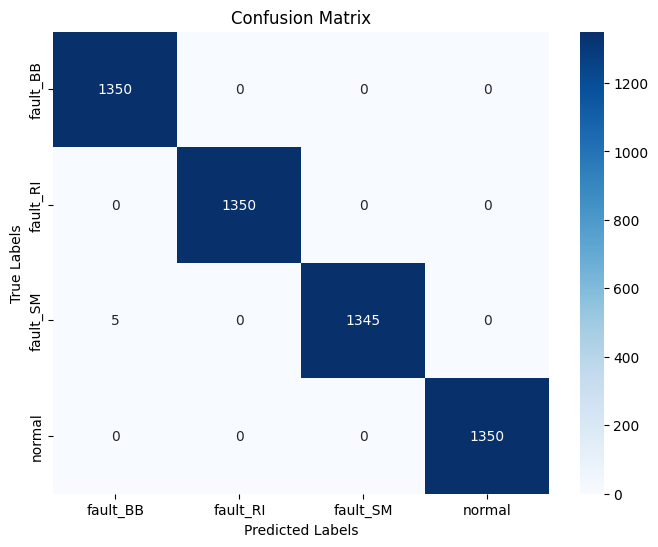

In [120]:
# 혼동 행렬 시각화 함수
def plot_confusion_matrix(conf_matrix, label_encoder):
    categories = label_encoder.classes_  # LabelEncoder의 순서대로 클래스 레이블을 가져옴
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# 평가 및 시각화 예시
val_loss, val_accuracy, val_conf_matrix = evaluate_model(model, val_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print("Confusion Matrix:")
print(val_conf_matrix)

# 혼동 행렬 시각화
plot_confusion_matrix(val_conf_matrix, label_encoder)